# TP Pytorch

In [ ]:
import math
import time
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.optim as optim

torch.set_default_dtype(torch.float32)

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cpu


PyTorch is a modern scientific computing and machine learning framework designed to make it easy to build, train, and experiment with models that rely on gradient-based optimization.

At its core, PyTorch provides two key ingredients:
- tensors, which are efficient data structures for numerical computation (similar to NumPy arrays, but with GPU support), and
- an automatic differentiation engine that can compute gradients of complex computations automatically.

For more information, please refer to the official website https://pytorch.org/ and to the official documentation https://docs.pytorch.org/docs/stable/index.html

This allows us to express models in a natural, mathematical way, by writing forward computations, while PyTorch takes care of building the underlying computational graph and propagating gradients backward when we call backward().

In this course, PyTorch will serve both as a practical tool for training models and as a concrete implementation of the theoretical concepts behind gradient descent and backpropagation.

In [ ]:
def numel(params):
    return sum(p.numel() for p in params)

def grad_norm(params):
    sq = 0.0
    for p in params:
        if p.grad is None:
            continue
        sq += float((p.grad.detach()**2).sum())
    return math.sqrt(sq)

def param_norm(params):
    sq = 0.0
    for p in params:
        sq += float((p.detach()**2).sum())
    return math.sqrt(sq)

# A First Example

Below is a simple example of training a simple NN model on a two-moods dataset.

In [ ]:
def make_two_moons(n=1000, noise=0.1):
    n1 = n // 2
    n2 = n - n1

    # Moon 1
    t1 = np.random.rand(n1) * np.pi
    x1 = np.c_[np.cos(t1), np.sin(t1)]

    # Moon 2
    t2 = np.random.rand(n2) * np.pi
    x2 = np.c_[1 - np.cos(t2), 0.5 - np.sin(t2)]

    X = np.vstack([x1, x2])
    y = np.hstack([np.zeros(n1, dtype=np.int64), np.ones(n2, dtype=np.int64)])

    # Add Gaussian noise
    X += noise * np.random.randn(*X.shape)

    # Shuffle
    idx = np.random.permutation(n)
    return X[idx], y[idx]

X_np, y_np = make_two_moons(n=2000, noise=0.15)

# Torch tensors
X = torch.tensor(X_np, dtype=torch.float32, device=device)
y = torch.tensor(y_np, dtype=torch.long, device=device)

# Train/val split
n = X.shape[0]
n_train = int(0.8 * n)
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:], y[n_train:]

print(X_train.shape, y_train.shape)

torch.Size([1600, 2]) torch.Size([1600])


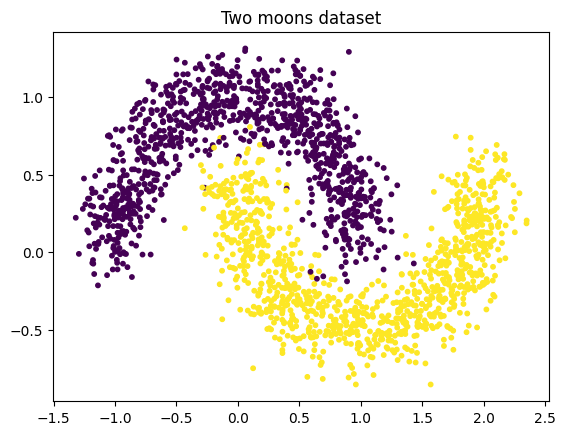

In [ ]:
plt.figure()
plt.scatter(X_np[:,0], X_np[:,1], c=y_np, s=10)
plt.title("Two moons dataset")
plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 2)   # 2 classes -> logits
).to(device)

loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-2)

step  100 | train loss 0.0325 | train acc 0.989 | val loss 0.0277 | val acc 0.995
step  200 | train loss 0.0239 | train acc 0.993 | val loss 0.0268 | val acc 0.990
step  300 | train loss 0.0222 | train acc 0.993 | val loss 0.0323 | val acc 0.990
step  400 | train loss 0.0212 | train acc 0.993 | val loss 0.0403 | val acc 0.990
step  500 | train loss 0.0207 | train acc 0.993 | val loss 0.0473 | val acc 0.990
step  600 | train loss 0.0204 | train acc 0.993 | val loss 0.0513 | val acc 0.990
step  700 | train loss 0.0200 | train acc 0.992 | val loss 0.0554 | val acc 0.990
step  800 | train loss 0.0197 | train acc 0.993 | val loss 0.0591 | val acc 0.990
step  900 | train loss 0.0194 | train acc 0.993 | val loss 0.0621 | val acc 0.990
step 1000 | train loss 0.0193 | train acc 0.993 | val loss 0.0646 | val acc 0.990


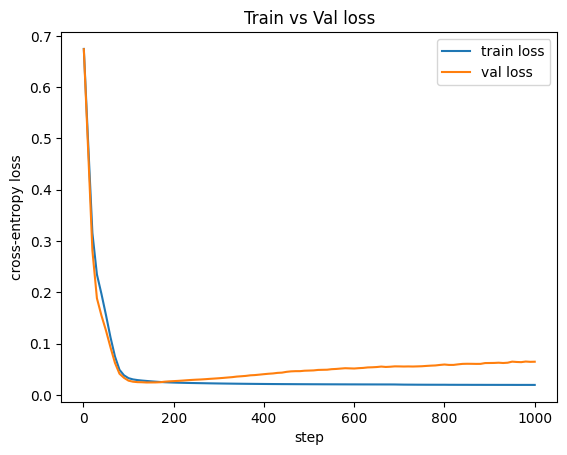

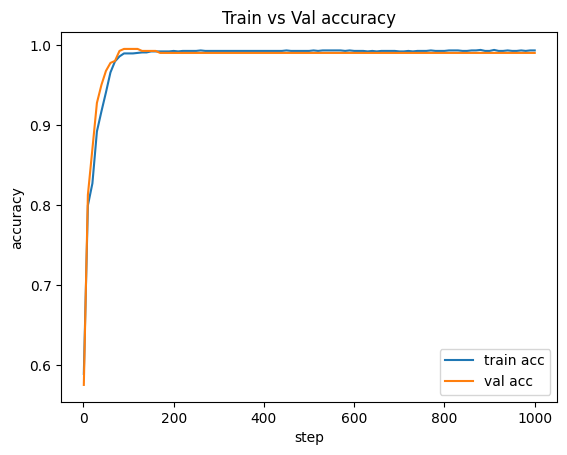

In [ ]:
def accuracy(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()


steps = 1000
eval_every = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []
record_steps = []

for step in range(1, steps + 1):
    model.train()
    logits = model(X_train)
    loss = loss_fn(logits, y_train)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % eval_every == 0 or step == 1:
        model.eval()
        with torch.no_grad():
            # train metrics
            train_logits = model(X_train)
            train_loss = loss_fn(train_logits, y_train).item()
            train_acc = accuracy(train_logits, y_train)

            # val metrics
            val_logits = model(X_val)
            val_loss = loss_fn(val_logits, y_val).item()
            val_acc = accuracy(val_logits, y_val)

        record_steps.append(step)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if step % 100 == 0:
            print(
                f"step {step:4d} | train loss {train_loss:.4f} | train acc {train_acc:.3f} "
                f"| val loss {val_loss:.4f} | val acc {val_acc:.3f}"
            )

# plot curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(record_steps, train_losses, label="train loss")
plt.plot(record_steps, val_losses, label="val loss")
plt.xlabel("step")
plt.ylabel("cross-entropy loss")
plt.legend()
plt.title("Train vs Val loss")
plt.show()

plt.figure()
plt.plot(record_steps, train_accs, label="train acc")
plt.plot(record_steps, val_accs, label="val acc")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.legend()
plt.title("Train vs Val accuracy")
plt.show()

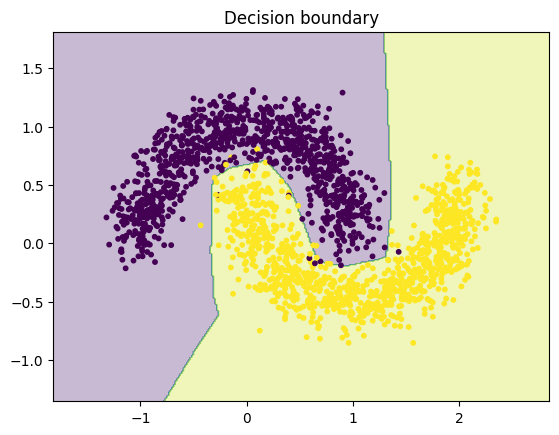

In [ ]:
def plot_decision_boundary(model, X_np, y_np, grid_steps=300):
    x_min, x_max = X_np[:,0].min() - 0.5, X_np[:,0].max() + 0.5
    y_min, y_max = X_np[:,1].min() - 0.5, X_np[:,1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_steps),
        np.linspace(y_min, y_max, grid_steps)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.tensor(grid, dtype=torch.float32, device=device)

    model.eval()
    with torch.no_grad():
        logits = model(grid_t)
        preds = logits.argmax(dim=1).cpu().numpy()

    Z = preds.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_np[:,0], X_np[:,1], c=y_np, s=10)
    plt.title("Decision boundary")
    plt.show()

plot_decision_boundary(model, X_np, y_np)

# Preliminary questions

**Question:** In the previous example, identify where we fix the architecture of the predictor. How many layers does the network have? How many neurons per layer?

The model is defined by

"
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 2)   # 2 classes -> logits
).to(device)
"

it has an input layer with dimension 2, two hidden layers with 16 neurons each, and an output layer of dimension 2.

**Question:** What is the number of trainable parameters in your model? Give a justification. You can double-check with the following command:

In [ ]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name:20s} | shape {tuple(p.shape)} | params {p.numel()}")

0.weight             | shape (16, 2) | params 32
0.bias               | shape (16,) | params 16
2.weight             | shape (16, 16) | params 256
2.bias               | shape (16,) | params 16
4.weight             | shape (2, 16) | params 32
4.bias               | shape (2,) | params 2


**Question :** By only changing a few lines in the previous code, implement a logistic regression instead of the current neural network.

The training loop of this introduction example is probably the most common you will encounter in Machine Learning. You can play with it by changing the linear maps, the activation functions, the loss, the optimizer, ... The rest of this TP presents tome in depth functions of Pytorch to allow you to master the software !

# Models with one hidden layer & random features

**Question:** Models with only one hidden layer are often used in theory for their simplicity. Provide code that implements them and vary the size of the intermediate layer. What can you say?

**Question:** Another interesting setting with neural networks with one hidden layer is the setting where we only train the last layer. The first layer is only initialized (with random weights) and never touched again. With PyTorch, it is possible to tell that a tensor t should not be trained by using t.requires_grad = False. Below, modify the code of the function make_one_hidden_layer_mlp to make sure that the first layer is not trained, and retrain the networks for different values of hidden dimension.

**Question:** Recast the problem as a logistic regression with a feature map that is randomly selected. Does the previous question suggest that random features are a good idea? This model is often used for theory, as it allows one to leverage the theory of linear models and convex analysis on top of a random extraction of features, which often allows avoiding the pitfall of non-convexity in neural networks.

# Custom Optimizers

PyTorch makes custom optimizers easy because parameters are plain tensors and, after loss.backward(), each trainable parameter p stores its gradient in p.grad. An optimizer is basically a rule that updates parameters using these gradients (and possibly some internal state like momentum). You can implement this either (i) by writing a simple “step” function that loops over parameters under torch.no_grad(), or (ii) by subclassing torch.optim.Optimizer to integrate nicely with the usual zero_grad()/step() workflow. In this section, we'll implement Signed SGD, which replaces the gradient direction by its sign: instead of moving by $-\eta \nabla$, we move by $-\eta\,\mathrm{sign}(\nabla)$. This keeps only directional information and can be more robust to gradient scale issues, but it may require smaller learning rates.

**Question:** Complete the following code to implement the signed SGD optimizer.

In [ ]:
from torch.optim.optimizer import Optimizer

class SignedSGD(Optimizer):
    """
    Signed SGD optimizer:
        p <- p - lr * sign(grad)
    Optional weight decay implemented as L2 regularization.
    """
    def __init__(self, params, lr=1e-2, weight_decay=0.0):
        if lr <= 0:
            raise ValueError(f"Invalid lr: {lr}")
        if weight_decay < 0:
            raise ValueError(f"Invalid weight_decay: {weight_decay}")
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            wd = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                g = p.grad

                # Optional L2 regularization (weight decay)
                if wd != 0.0:
                    COMPLETE HERE

                # Signed update
                COMPLETE HERE

        return loss

SyntaxError: invalid syntax (ipython-input-2487942670.py, line 35)

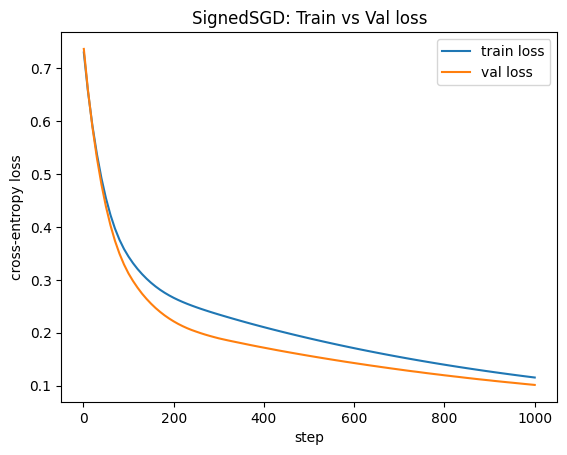

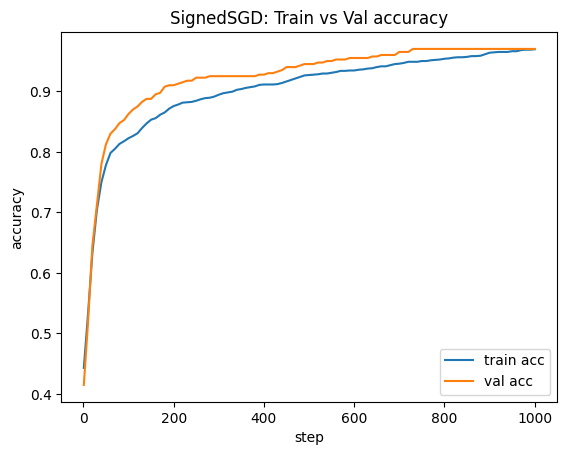

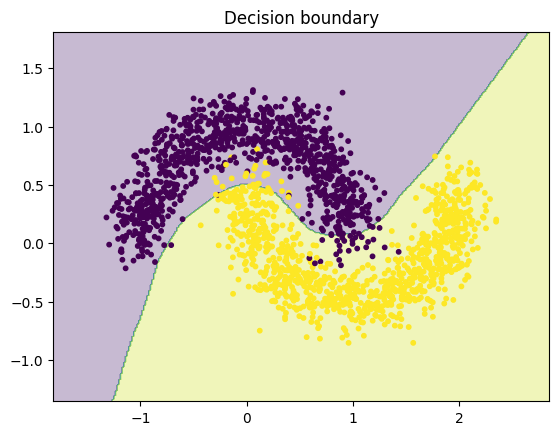

In [ ]:
import matplotlib.pyplot as plt

model = make_one_hidden_layer_mlp(64, device)
loss_fn = nn.CrossEntropyLoss()
opt = SignedSGD(model.parameters(), lr=1e-3, weight_decay=1e-4)

steps = 1000
eval_every = 10

record_steps = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for step in range(1, steps + 1):
    model.train()
    logits = model(X_train)
    loss = loss_fn(logits, y_train)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % eval_every == 0 or step == 1:
        model.eval()
        with torch.no_grad():
            train_logits = model(X_train)
            train_loss = loss_fn(train_logits, y_train).item()
            train_acc = accuracy(train_logits, y_train)

            val_logits = model(X_val)
            val_loss = loss_fn(val_logits, y_val).item()
            val_acc = accuracy(val_logits, y_val)

        record_steps.append(step)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

# plot curves
plt.figure()
plt.plot(record_steps, train_losses, label="train loss")
plt.plot(record_steps, val_losses, label="val loss")
plt.xlabel("step")
plt.ylabel("cross-entropy loss")
plt.legend()
plt.title("SignedSGD: Train vs Val loss")
plt.show()

plt.figure()
plt.plot(record_steps, train_accs, label="train acc")
plt.plot(record_steps, val_accs, label="val acc")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.legend()
plt.title("SignedSGD: Train vs Val accuracy")
plt.show()

# decision boundary
plot_decision_boundary(model, X_np, y_np)

# Hessian vector products





Let $ f : \mathbb{R}^d \to \mathbb{R} $ be a twice differentiable scalar function.
Its gradient is $ \nabla f(x) \in \mathbb{R}^d $ and its Hessian is
$$
\nabla^2 f(x) \in \mathbb{R}^{d \times d}.
$$

In many applications, we do not need the full Hessian matrix, but only its
product with a vector $ v \in \mathbb{R}^d $,
$$
\nabla^2 f(x)\, v.
$$

A key identity makes this easy to compute with automatic differentiation:
$$
\nabla^2 f(x)\, v
\;=\;
\nabla_x \bigl( \langle \nabla f(x), v \rangle \bigr).
$$

In words:  
a Hessian-vector product is the gradient of the scalar product between the gradient and a vector.

This identity allows us to compute Hessian-vector products efficiently:
- without explicitly forming the Hessian,
- at a cost comparable to a single backward pass.

**Question :** Complete the following code to implement a hessian vector product on the function $f$.

In [ ]:
import torch

# --- setup ---
torch.manual_seed(0)
x = torch.randn(5, requires_grad=True)
v = torch.randn(5)

# Define a scalar function f(x)
def f(x):
    return (x**3).sum()

# Step 1: compute the gradient
# TODO: compute grad_f = ∇f(x)


# Step 2: form the scalar product <∇f(x), v>
# TODO: compute the scalar product between grad_f and v


# Step 3: differentiate again
# TODO: compute the gradient of the scalar w.r.t. x

print("Hessian-vector product (autodiff):")
print(hvp)

# Optional check (explicit Hessian, small dimension only)
# WARNING: this is inefficient and only for verification
H = torch.zeros(x.numel(), x.numel())
for i in range(x.numel()):
    grad_i = torch.autograd.grad(grad_f[i], x, retain_graph=True)[0]
    H[i] = grad_i

print("\nExplicit Hessian @ v:")
print(H @ v)


Hessian-vector product (autodiff):
tensor([-12.9314,  -0.7101, -10.9553,  -2.4531,   2.6246])


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.